# Modélisation du prix du m² à lille (année2022) pour les logements de 4 pièces, Séparation appartements vs maisons

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement , exploration et vérification des données 

In [2]:
# Configuration des graphiques
plt.style.use('default')
sns.set_palette('husl')

def load_and_explore_data():
    """ Charger les données de Lille"""
    print(" Chargement des données de Lille...")
    
    df = pd.read_csv("../data/lille_2022.csv")
    print(f" Données chargées : {len(df)} transactions")
    
    # Explorer les colonnes disponibles
    print(" Colonnes disponibles :")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Vérifier les types de logements
    if 'Type local' in df.columns:
        print(f" Types de logements :")
        print(df['Type local'].value_counts())
    
    # Vérifier les nombres de pièces
    if 'Nombre pieces principales' in df.columns:
        print(f" Répartition nombre de pièces :")
        print(df['Nombre pieces principales'].value_counts().sort_index())
    
    return df

# Appel de  la fonction pour charger et explorer les données
df = load_and_explore_data()

 Chargement des données de Lille...
 Données chargées : 11354 transactions
 Colonnes disponibles :
   1. Identifiant de document
   2. Reference document
   3. 1 Articles CGI
   4. 2 Articles CGI
   5. 3 Articles CGI
   6. 4 Articles CGI
   7. 5 Articles CGI
   8. No disposition
   9. Date mutation
  10. Nature mutation
  11. Valeur fonciere
  12. No voie
  13. B/T/Q
  14. Type de voie
  15. Code voie
  16. Voie
  17. Code postal
  18. Commune
  19. Code departement
  20. Code commune
  21. Prefixe de section
  22. Section
  23. No plan
  24. No Volume
  25. 1er lot
  26. Surface Carrez du 1er lot
  27. 2eme lot
  28. Surface Carrez du 2eme lot
  29. 3eme lot
  30. Surface Carrez du 3eme lot
  31. 4eme lot
  32. Surface Carrez du 4eme lot
  33. 5eme lot
  34. Surface Carrez du 5eme lot
  35. Nombre de lots
  36. Code type local
  37. Type local
  38. Identifiant local
  39. Surface reelle bati
  40. Nombre pieces principales
  41. Nature culture
  42. Nature culture speciale
  43. Surf

## Filtrage des logements 4 pièces ,séparation maisons / appartements

In [3]:
def filter_4_pieces_data(df):
    """ Filtrer les logements de 4 pièces"""
    print(" Filtrage des logements 4 pièces...")
    
    # Filtrer les 4 pièces
    df_4p = df[df['Nombre pieces principales'] == 4].copy()
    print(f" Logements 4 pièces : {len(df_4p)} transactions")
    
    if len(df_4p) == 0:
        print(" Aucun logement 4 pièces trouvé !")
        return None, None
    
    # Vérifier les types de logements dans les 4 pièces
    print(f" Types de logements 4 pièces :")
    print(df_4p['Type local'].value_counts())
    
    return(df_4p)
    #appel de la fonction
df_4p = filter_4_pieces_data(df)



 Filtrage des logements 4 pièces...
 Logements 4 pièces : 789 transactions
 Types de logements 4 pièces :
Type local
Appartement    435
Maison         354
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split  

#Créer les variables
appartements = df_4p[df_4p['Type local'] == 'Appartement'].copy()
maisons = df_4p[df_4p['Type local'] == 'Maison'].copy()

print(f" Appartements 4 pièces : {len(appartements)}")
print(f" Maisons 4 pièces : {len(maisons)}")

#   Définir la fonction de nettoyage
def select_features_and_clean(df, dataset_name):
    """Sélectionner les colonnes et nettoyer"""
    print(f" Nettoyage données {dataset_name}...")
    
    if len(df) == 0:
        print(f" Aucune donnée pour {dataset_name}")
        return None, None, None
    
    # Colonnes à conserver
    required_cols = ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere']
    optional_cols = ['Surface terrain', 'Nombre de lots']
    
    # Vérifier colonnes disponibles
    available_cols = [col for col in required_cols if col in df.columns]
    available_optional = [col for col in optional_cols if col in df.columns]
    
    print(f" Colonnes disponibles : {available_cols + available_optional}")
    
    # Sélectionner et nettoyer
    selected_cols = available_cols + available_optional
    df_clean = df[selected_cols].copy()
    
    # Créer prix_m2 (Variable cible)
    df_clean['prix_m2'] = df_clean['Valeur fonciere'] / df_clean['Surface reelle bati']
    print(f" Variable prix_m2 créée")
    
    # Nettoyage
    print(f" Avant nettoyage : {len(df_clean)} lignes")
    
    # Remplacer valeurs manquantes 
    if 'Surface terrain' in df_clean.columns:
        df_clean['Surface terrain'] = df_clean['Surface terrain'].fillna(0)
    if 'Nombre de lots' in df_clean.columns:
        df_clean['Nombre de lots'] = df_clean['Nombre de lots'].fillna(1)
    
    # Supprimer lignes avec données essentielles manquantes
    df_clean = df_clean.dropna(subset=['Surface reelle bati', 'Valeur fonciere'])
    print(f" Après nettoyage valeurs manquantes : {len(df_clean)} lignes")
    
    # Identifier et retirer les valeurs aberrantes (prix au m²)
    if len(df_clean) > 0:
        Q1 = df_clean['prix_m2'].quantile(0.25)
        Q3 = df_clean['prix_m2'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Limites pour les outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(f" Détection outliers prix_m2 :")
        print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}")
        print(f"   Limites: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # Filtrer les outliers
        mask = (df_clean['prix_m2'] >= lower_bound) & (df_clean['prix_m2'] <= upper_bound)
        df_clean = df_clean[mask]
        
        print(f" Après suppression outliers : {len(df_clean)} lignes")
    
    if len(df_clean) == 0:
        print(f" Plus de données après nettoyage pour {dataset_name}")
        return None, None, None
    
    # Préparer X et y
    feature_cols = [col for col in df_clean.columns if col not in ['Valeur fonciere', 'prix_m2', 'Type local']]
    X = df_clean[feature_cols]
    y = df_clean['prix_m2']
        
    # Afficher quelques statistiques
    print(f"  Statistiques {dataset_name} :")
    print(f"  Prix m² min: {df_clean['prix_m2'].min():.2f} €")
    print(f"  Prix m² max: {df_clean['prix_m2'].max():.2f} €")
    print(f"  Prix m² moyen: {df_clean['prix_m2'].mean():.2f} €")
    print(f"  Variables : {list(X.columns)}")
    
    return X, y, df_clean

# Appeler la fonction
print("\n=== NETTOYAGE APPARTEMENTS ===")
X_apt, y_apt, df_apt_clean = select_features_and_clean(appartements, "APPARTEMENTS")

print("\n=== NETTOYAGE MAISONS ===")
X_maisons, y_maisons, df_maisons_clean = select_features_and_clean(maisons, "MAISONS")







 Appartements 4 pièces : 435
 Maisons 4 pièces : 354

=== NETTOYAGE APPARTEMENTS ===
 Nettoyage données APPARTEMENTS...
 Colonnes disponibles : ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere', 'Surface terrain', 'Nombre de lots']
 Variable prix_m2 créée
 Avant nettoyage : 435 lignes
 Après nettoyage valeurs manquantes : 435 lignes
 Détection outliers prix_m2 :
   Q1: 2617.08, Q3: 4310.38
   Limites: [77.12, 6850.34]
 Après suppression outliers : 386 lignes
  Statistiques APPARTEMENTS :
  Prix m² min: 416.67 €
  Prix m² max: 6824.32 €
  Prix m² moyen: 3352.36 €
  Variables : ['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Nombre de lots']

=== NETTOYAGE MAISONS ===
 Nettoyage données MAISONS...
 Colonnes disponibles : ['Surface reelle bati', 'Nombre pieces principales', 'Type local', 'Valeur fonciere', 'Surface terrain', 'Nombre de lots']
 Variable prix_m2 créée
 Avant nettoyage : 354 lignes
 Après nettoyage valeurs manquante

In [5]:
## Exploration des données 

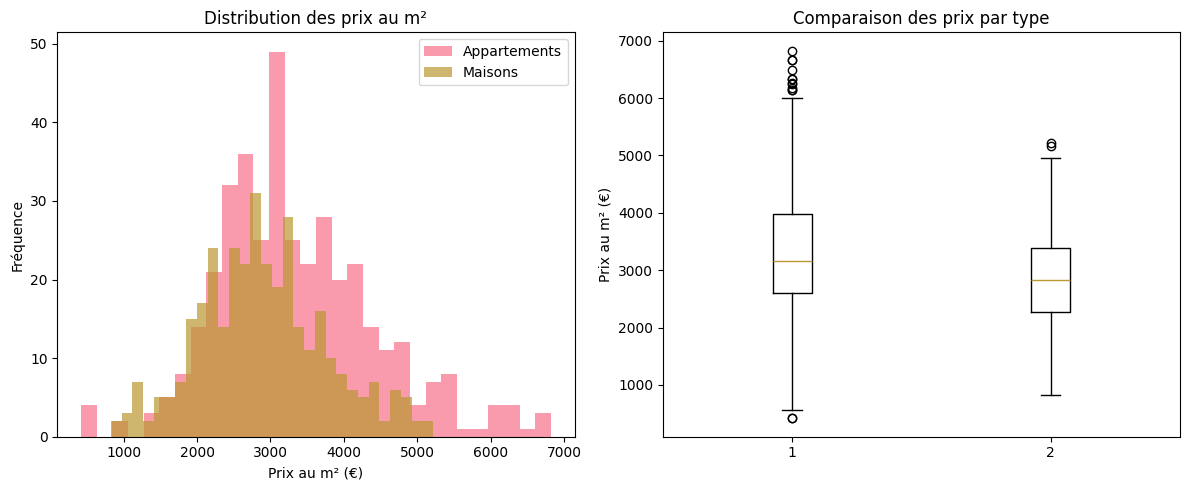

In [6]:
# Comparer les distributions de prix
if df_apt_clean is not None and df_maisons_clean is not None:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_apt_clean['prix_m2'], bins=30, alpha=0.7, label='Appartements')
    plt.hist(df_maisons_clean['prix_m2'], bins=30, alpha=0.7, label='Maisons')
    plt.xlabel('Prix au m² (€)')
    plt.ylabel('Fréquence')
    plt.title('Distribution des prix au m²')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot([df_apt_clean['prix_m2'], df_maisons_clean['prix_m2']], 
                label=['Appartements', 'Maisons'])
    plt.ylabel('Prix au m² (€)')
    plt.title('Comparaison des prix par type')
    plt.tight_layout()
    plt.show()

## Division en jeu d'entraînement (80%) et test (20%) avec train_test_split

In [7]:
#  Division train/test 
if X_apt is not None:
    X_train_apt, X_test_apt, y_train_apt, y_test_apt = train_test_split(
        X_apt, y_apt, test_size=0.2, random_state=42
    )
    print(f" Appartements - Train: {len(X_train_apt)}, Test: {len(X_test_apt)}")

if X_maisons is not None:
    X_train_maisons, X_test_maisons, y_train_maisons, y_test_maisons = train_test_split(
        X_maisons, y_maisons, test_size=0.2, random_state=42
    )
    print(f" Maisons - Train: {len(X_train_maisons)}, Test: {len(X_test_maisons)}")

 Appartements - Train: 308, Test: 78
 Maisons - Train: 272, Test: 69


##  Corrèlations des variables avec le prix au m²

In [8]:

print(" Corrélations avec prix_m2:")

# Appartements
if df_apt_clean is not None:
    print(" APPARTEMENTS:")
    numeric_cols = df_apt_clean.select_dtypes(include=[np.number])
    print(numeric_cols.corr()['prix_m2'].sort_values(ascending=False))

# Maisons  
if df_maisons_clean is not None:
    print(" MAISONS:")
    numeric_cols = df_maisons_clean.select_dtypes(include=[np.number])
    print(numeric_cols.corr()['prix_m2'].sort_values(ascending=False))





 Corrélations avec prix_m2:
 APPARTEMENTS:
prix_m2                      1.000000
Valeur fonciere              0.816847
Surface reelle bati          0.281777
Surface terrain              0.129676
Nombre de lots               0.047431
Nombre pieces principales         NaN
Name: prix_m2, dtype: float64
 MAISONS:
prix_m2                      1.000000
Valeur fonciere              0.754197
Surface terrain              0.142383
Nombre de lots              -0.044690
Surface reelle bati         -0.053308
Nombre pieces principales         NaN
Name: prix_m2, dtype: float64


## Standardisation (uniquement pour x ) et entrainement du modèle 

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Pour les appartements
if X_train_apt is not None:
    scaler_apt = StandardScaler()
    X_train_apt_scaled = scaler_apt.fit_transform(X_train_apt)
    X_test_apt_scaled = scaler_apt.transform(X_test_apt)

# Pour les maisons
if X_train_maisons is not None:
    scaler_maisons = StandardScaler()
    X_train_maisons_scaled = scaler_maisons.fit_transform(X_train_maisons)
    X_test_maisons_scaled = scaler_maisons.transform(X_test_maisons)

## Modèle de régréssion linéaire 



In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("Régression Linéaire...")

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS")
    lr_apt = LinearRegression()
    lr_apt.fit(X_train_apt_scaled, y_train_apt)  
    y_pred_lr_apt = lr_apt.predict(X_test_apt_scaled)
    mse_lr_apt = mean_squared_error(y_test_apt, y_pred_lr_apt)
    rmse_lr_apt = np.sqrt(mse_lr_apt)
    r2_lr_apt = r2_score(y_test_apt, y_pred_lr_apt)
    print(f"-MSE: {mse_lr_apt:.2f}")
    print(f"-RMSE: {rmse_lr_apt:>12,.2f} €/m²")
    print(f"-R²:   {r2_lr_apt:>12.3f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print(" MAISONS")
    lr_maisons = LinearRegression()
    lr_maisons.fit(X_train_maisons_scaled, y_train_maisons)  
    y_pred_lr_maisons = lr_maisons.predict(X_test_maisons_scaled)

    mse_lr_maisons = mean_squared_error(y_test_maisons, y_pred_lr_maisons)
    rmse_lr_maisons = np.sqrt(mse_lr_maisons)
    r2_lr_maisons = r2_score(y_test_maisons, y_pred_lr_maisons)
    print(f"-MSE: {mse_lr_maisons:.2f}")
    print(f"-RMSE: {rmse_lr_maisons:>12,.2f} €/m²")
    print(f"-R²:   {r2_lr_maisons:>12.3f}")
    

Régression Linéaire...
 APPARTEMENTS
-MSE: 1495078.04
-RMSE:     1,222.73 €/m²
-R²:         -0.114
 MAISONS
-MSE: 607924.10
-RMSE:       779.69 €/m²
-R²:          0.032


## Modèle décision threeregressor avec hyper-paramètres

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


print(" DECISION TREE REGRESSOR")
print("=" * 40)

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS - Decision Tree")
    dt_apt = DecisionTreeRegressor(
        random_state=42,    # ramdom state fix 
        max_depth=10,       # limite de profondeur
        min_samples_split=5,# minimun d'échantillon pour la division
        min_samples_leaf=2) # minimun d'échantillon /feuille 
    dt_apt.fit(X_train_apt_scaled, y_train_apt)
    y_pred_dt_apt = dt_apt.predict(X_test_apt_scaled)

    #calcul des metrics 
    mse_dt_apt = mean_squared_error(y_test_apt, y_pred_dt_apt)
    rmse_dt_apt = np.sqrt(mse_dt_apt)
    r2_dt_apt = r2_score(y_test_apt, y_pred_dt_apt)
    print(f"-MSE:  {mse_dt_apt:>12,.2f}")
    print(f"-RMSE: {rmse_dt_apt:>12,.2f} €/m²")
    print(f"-R²:   {r2_dt_apt:>12.3f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print(" MAISONS - Decision Tree")
    dt_maisons = DecisionTreeRegressor(
        random_state=42,     # ramdom state fix 
        max_depth=10,        # # Limite de profondeur
        min_samples_split=5, # Minimun d'échantillon pour la division
        min_samples_leaf=2   # Minimum d'échantillons / feuille
    )
    dt_maisons.fit(X_train_maisons_scaled, y_train_maisons)
    y_pred_dt_maisons = dt_maisons.predict(X_test_maisons_scaled)

    #calcul des metrics
    mse_dt_maisons = mean_squared_error(y_test_maisons, y_pred_dt_maisons)
    rmse_dt_maisons = np.sqrt(mse_dt_maisons)
    r2_dt_maisons = r2_score(y_test_maisons, y_pred_dt_maisons)
    
    #affichage des metrcis avec formatage 
    print(f"-MSE: {mse_dt_maisons:>12,.2f}")
    print(f"-RMSE: {rmse_dt_maisons:>12,.2f} €/m²")
    print(f"-R²:   {r2_dt_maisons:>12.3f}")

 DECISION TREE REGRESSOR
 APPARTEMENTS - Decision Tree
-MSE:  1,646,782.03
-RMSE:     1,283.27 €/m²
-R²:         -0.227
 MAISONS - Decision Tree
-MSE:   966,355.82
-RMSE:       983.03 €/m²
-R²:         -0.538


## Modèle ramdom forest avec hyper-paramètres 

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


print("\n RANDOM FOREST REGRESSOR")
print("=" * 40)

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS - Random Forest")
    rf_apt = RandomForestRegressor(n_estimators=50, random_state=42)    # radomstate fix pour la reprodubilité 
    rf_apt.fit(X_train_apt_scaled, y_train_apt)
    y_pred_rf_apt = rf_apt.predict(X_test_apt_scaled)
    
    # Calcul des métrics 
    mse_rf_apt = mean_squared_error(y_test_apt, y_pred_rf_apt)
    rmse_rf_apt = np.sqrt(mse_dt_apt)
    r2_rf_apt = r2_score(y_test_apt, y_pred_rf_apt)
    print(f"-MSE: {mse_rf_apt:.2f}")
    print(f"-RMSE: {rmse_rf_apt:>12,.2f} €/m²")
    print(f"-R²:   {r2_rf_apt:>12.3f}")


# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print("MAISONS - Random Forest")
    rf_maisons = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_maisons.fit(X_train_maisons_scaled, y_train_maisons)
    y_pred_rf_maisons = rf_maisons.predict(X_test_maisons_scaled)

    # Calcul des métrics 
    mse_rf_maisons = mean_squared_error(y_test_maisons, y_pred_rf_maisons)
    rmse_rf_maisons = np.sqrt(mse_rf_maisons)
    r2_rf_maisons = r2_score(y_test_maisons, y_pred_rf_maisons)
    print(f"-MSE: {mse_rf_maisons:.2f}")
    print(f"-RMSE: {rmse_rf_maisons:>12,.2f} €/m²")
    print(f"-R²:   {r2_rf_maisons:>12.3f}")







 RANDOM FOREST REGRESSOR
 APPARTEMENTS - Random Forest
-MSE: 1551463.29
-RMSE:     1,283.27 €/m²
-R²:         -0.156
MAISONS - Random Forest
-MSE: 610034.53
-RMSE:       781.05 €/m²
-R²:          0.029


In [13]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print(" OPTIMISATION AVEC GRIDSEARCHCV")
print("=" * 50)

# OPTIMISATION DECISION TREE


print("\n OPTIMISATION DECISION TREE")
print("-" * 40)

# Paramètres à tester pour Decision Tree
dt_params = {
    'max_depth': [5, 8, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_impurity_decrease': [0.0, 0.01]
}

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS - Decision Tree GridSearch")
    
    dt_grid_apt = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        dt_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    dt_grid_apt.fit(X_train_apt_scaled, y_train_apt)
    
    # Prédictions avec le meilleur modèle
    y_pred_dt_opt_apt = dt_grid_apt.predict(X_test_apt_scaled)
    
    # Métriques
    mse_dt_opt_apt = mean_squared_error(y_test_apt, y_pred_dt_opt_apt)
    rmse_dt_opt_apt = np.sqrt(mse_dt_opt_apt)
    r2_dt_opt_apt = r2_score(y_test_apt, y_pred_dt_opt_apt)
    
    print(f"   Meilleurs paramètres: {dt_grid_apt.best_params_}")
    print(f"   MSE optimisé:  {mse_dt_opt_apt:>12,.2f}")
    print(f"   RMSE optimisé: {rmse_dt_opt_apt:>12,.2f} €/m²")
    print(f"   R² optimisé:   {r2_dt_opt_apt:>12.3f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print("\n MAISONS - Decision Tree GridSearch")
    
    dt_grid_maisons = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        dt_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    dt_grid_maisons.fit(X_train_maisons_scaled, y_train_maisons)
    
    # Prédictions avec le meilleur modèle
    y_pred_dt_opt_maisons = dt_grid_maisons.predict(X_test_maisons_scaled)
    
    # Métriques
    mse_dt_opt_maisons = mean_squared_error(y_test_maisons, y_pred_dt_opt_maisons)
    rmse_dt_opt_maisons = np.sqrt(mse_dt_opt_maisons)
    r2_dt_opt_maisons = r2_score(y_test_maisons, y_pred_dt_opt_maisons)
    
    print(f"   Meilleurs paramètres: {dt_grid_maisons.best_params_}")
    print(f"   MSE optimisé:  {mse_dt_opt_maisons:>12,.2f}")
    print(f"   RMSE optimisé: {rmse_dt_opt_maisons:>12,.2f} €/m²")
    print(f"   R² optimisé:   {r2_dt_opt_maisons:>12.3f}")

# OPTIMISATION RANDOM FOREST


print("\n OPTIMISATION RANDOM FOREST")
print("-" * 40)

# Paramètres à tester pour Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Pour les appartements
if 'X_train_apt_scaled' in locals():
    print(" APPARTEMENTS - Random Forest GridSearch")
    
    grid_rf_apt = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        rf_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_rf_apt.fit(X_train_apt_scaled, y_train_apt)
    
    # Prédictions avec le meilleur modèle
    y_pred_rf_opt_apt = grid_rf_apt.predict(X_test_apt_scaled)
    
    # Métriques
    mse_rf_opt_apt = mean_squared_error(y_test_apt, y_pred_rf_opt_apt)
    rmse_rf_opt_apt = np.sqrt(mse_rf_opt_apt)
    r2_rf_opt_apt = r2_score(y_test_apt, y_pred_rf_opt_apt)
    
    print(f"- Meilleurs paramètres: {grid_rf_apt.best_params_}")
    print(f"- MSE optimisé:  {mse_rf_opt_apt:>12,.2f}")
    print(f"- RMSE optimisé: {rmse_rf_opt_apt:>12,.2f} €/m²")
    print(f"- R² optimisé:   {r2_rf_opt_apt:>12.3f}")

# Pour les maisons
if 'X_train_maisons_scaled' in locals():
    print("\n MAISONS - Random Forest GridSearch")
    
    dt_grid_maisons = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        rf_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    dt_grid_maisons.fit(X_train_maisons_scaled, y_train_maisons)
    
    # Prédictions avec le meilleur modèle
    y_pred_rf_opt_maisons = dt_grid_maisons.predict(X_test_maisons_scaled)
    
    # Métriques
    mse_rf_opt_maisons = mean_squared_error(y_test_maisons, y_pred_rf_opt_maisons)
    rmse_rf_opt_maisons = np.sqrt(mse_rf_opt_maisons)
    r2_rf_opt_maisons = r2_score(y_test_maisons, y_pred_rf_opt_maisons)
    
    print(f"   Meilleurs paramètres: {dt_grid_maisons.best_params_}")
    print(f"   MSE optimisé:  {mse_rf_opt_maisons:>12,.2f}")
    print(f"   RMSE optimisé: {rmse_rf_opt_maisons:>12,.2f} €/m²")
    print(f"   R² optimisé:   {r2_rf_opt_maisons:>12.3f}")

print("\n Optimisation GridSearchCV terminée !")





 OPTIMISATION AVEC GRIDSEARCHCV

 OPTIMISATION DECISION TREE
----------------------------------------
 APPARTEMENTS - Decision Tree GridSearch
Fitting 5 folds for each of 90 candidates, totalling 450 fits
   Meilleurs paramètres: {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10}
   MSE optimisé:  1,731,723.21
   RMSE optimisé:     1,315.95 €/m²
   R² optimisé:         -0.290

 MAISONS - Decision Tree GridSearch
Fitting 5 folds for each of 90 candidates, totalling 450 fits
   Meilleurs paramètres: {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5}
   MSE optimisé:    651,703.56
   RMSE optimisé:       807.28 €/m²
   R² optimisé:         -0.037

 OPTIMISATION RANDOM FOREST
----------------------------------------
 APPARTEMENTS - Random Forest GridSearch
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
- Meilleurs paramètres: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4

## Visualisation vraie valeur / prédiction

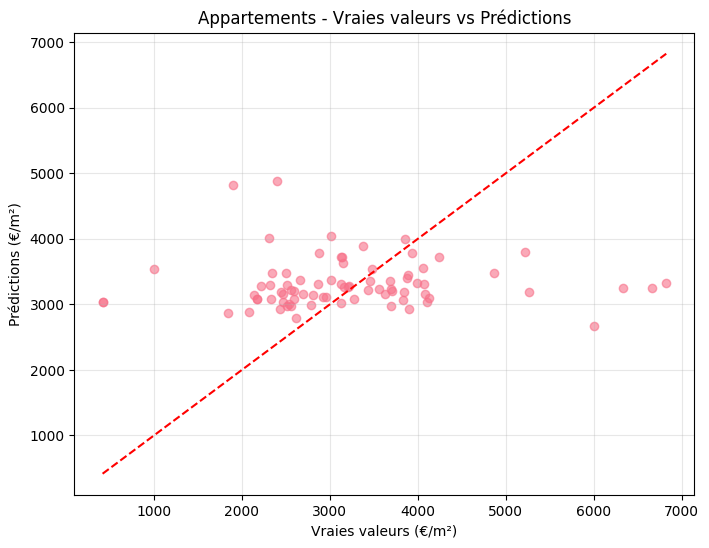

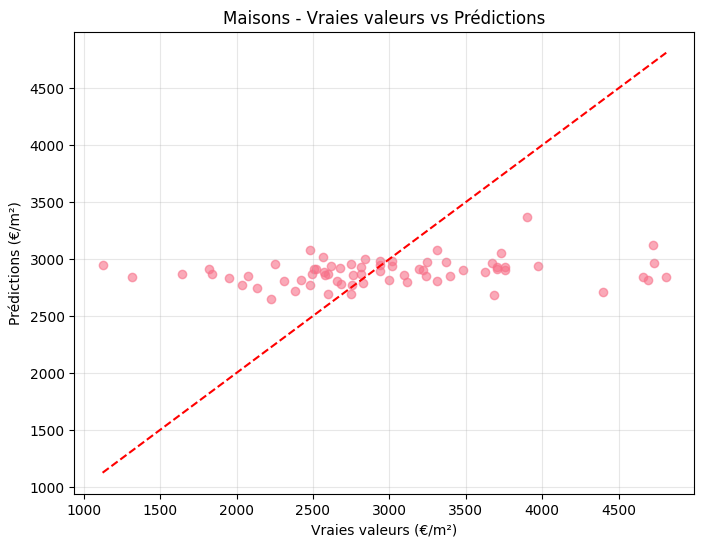

In [14]:
import matplotlib.pyplot as plt

# Visualisation Appartements
if 'y_pred_lr_apt' in locals():
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_apt, y_pred_lr_apt, alpha=0.6)  
    plt.plot([y_test_apt.min(), y_test_apt.max()], 
             [y_test_apt.min(), y_test_apt.max()], 
             color="red", linestyle="--")
    plt.xlabel("Vraies valeurs (€/m²)")
    plt.ylabel("Prédictions (€/m²)")
    plt.title("Appartements - Vraies valeurs vs Prédictions")
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualisation Maisons
if 'y_pred_lr_maisons' in locals():
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_maisons, y_pred_lr_maisons, alpha=0.6)  
    plt.plot([y_test_maisons.min(), y_test_maisons.max()], 
             [y_test_maisons.min(), y_test_maisons.max()], 
             color="red", linestyle="--")
    plt.xlabel("Vraies valeurs (€/m²)")
    plt.ylabel("Prédictions (€/m²)")
    plt.title("Maisons - Vraies valeurs vs Prédictions")
    plt.grid(True, alpha=0.3)
    plt.show()

In [15]:
# Imports et vérification XGBoost
try:
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    XGBOOST_AVAILABLE = True
    print(" XGBoost disponible")
except ImportError:
    print(" XGBoost non disponible. Installez avec: pip install xgboost")
    XGBOOST_AVAILABLE = False

# XGBoost pour les appartements
if XGBOOST_AVAILABLE and 'X_train_apt_scaled' in locals():
    print(" XGBoost APPARTEMENTS...")
    xgb_apt = XGBRegressor(random_state=42, eval_metric='rmse')
    xgb_apt.fit(X_train_apt_scaled, y_train_apt) 
    y_pred_xgb_apt = xgb_apt.predict(X_test_apt_scaled)
    mse_xgb_apt = mean_squared_error(y_test_apt, y_pred_xgb_apt)
    rmse_xgb_apt = np.sqrt(mse_xgb_apt)
    r2_xgb_apt = r2_score(y_test_apt, y_pred_xgb_apt)
    
    print(f"   MSE:  {mse_xgb_apt:>12,.2f}")
    print(f"   RMSE: {rmse_xgb_apt:>12,.2f} €/m²")
    print(f"   R²:   {r2_xgb_apt:>12.3f}")

# XGBoost pour les maisons
if XGBOOST_AVAILABLE and 'X_train_maisons_scaled' in locals():
    print("\n XGBoost MAISONS...")
    xgb_maisons = XGBRegressor(random_state=42, eval_metric='rmse')
    xgb_maisons.fit(X_train_maisons_scaled, y_train_maisons) 
    y_pred_xgb_maisons = xgb_maisons.predict(X_test_maisons_scaled)
    mse_xgb_maisons = mean_squared_error(y_test_maisons, y_pred_xgb_maisons)
    rmse_xgb_maisons = np.sqrt(mse_xgb_maisons)
    r2_xgb_maisons = r2_score(y_test_maisons, y_pred_xgb_maisons)
    
    print(f"   MSE:  {mse_xgb_maisons:>12,.2f}")
    print(f"   RMSE: {rmse_xgb_maisons:>12,.2f} €/m²")
    print(f"   R²:   {r2_xgb_maisons:>12.3f}")

 XGBoost disponible
 XGBoost APPARTEMENTS...
   MSE:  1,508,578.18
   RMSE:     1,228.24 €/m²
   R²:         -0.124

 XGBoost MAISONS...
   MSE:    988,573.85
   RMSE:       994.27 €/m²
   R²:         -0.573


## Sauvegarde des modèle

In [16]:
import joblib

# 1. Extraire les meilleurs modèles depuis vos GridSearchCV
best_model_apt = dt_grid_apt.best_estimator_
best_model_maisons = dt_grid_maisons.best_estimator_

print(f"Meilleur modèle appartements: {type(best_model_apt).__name__}")
print(f"Paramètres apt: {dt_grid_apt.best_params_}")

print(f"Meilleur modèle maisons: {type(best_model_maisons).__name__}")
print(f"Paramètres maisons: {dt_grid_maisons.best_params_}")

# 2. Sauvegarder les MEILLEURS modèles (pas les LinearRegression)
joblib.dump(best_model_apt, '../models/lille_appartements.pkl')        # ← Random Forest optimisé
joblib.dump(best_model_maisons, '../models/lille_maisons.pkl')         # ← Random Forest optimisé
joblib.dump(scaler_apt, '../models/scaler_lille_apt.pkl')
joblib.dump(scaler_maisons, '../models/scaler_lille_maisons.pkl')

# 3. Optionnel : garder aussi les objets GridSearchCV complets
joblib.dump(dt_grid_maisons, '../models/grid_lille_maisons.pkl')
joblib.dump(dt_grid_apt, '../models/grid_lille_appartement.pkl')

print("✅ Modèles OPTIMISÉS sauvegardés (Random Forest)")
print("✅ Scalers sauvegardés")
print("✅ GridSearchCV complets sauvegardés")

# 4. Vérification
print(f"\nModèle appartements sauvé: {type(best_model_apt).__name__}")
print(f"Modèle maisons sauvé: {type(best_model_maisons).__name__}")

Meilleur modèle appartements: DecisionTreeRegressor
Paramètres apt: {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10}
Meilleur modèle maisons: RandomForestRegressor
Paramètres maisons: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Modèles OPTIMISÉS sauvegardés (Random Forest)
✅ Scalers sauvegardés
✅ GridSearchCV complets sauvegardés

Modèle appartements sauvé: DecisionTreeRegressor
Modèle maisons sauvé: RandomForestRegressor
